In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statistics as s
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_fscore_support
from math import log
import pickle

### Overview

The goal of the project is to create a method to identify the user Joe using data about user sessions that have been recorded over a period of time.

In [2]:
df = pd.read_json('dataset.json')
# number of entries in the original dataframe
n_entries = df.shape[0]
df.shape

(80000, 9)

In [3]:
df.head()

,browser,os,locale,user_id,gender,location,sites,time,date
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",21:49:00,2017-06-25
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10


### Auxiliary Functions

Functions to facilitate data process ahead

In [4]:
def plot_classes_diff(pos, neg, key):
    '''
    Plot one pie chart per class.
    
            Parameters:
                    pos (tuple): list of labels and values of each session of the pie chart for positive class
                    neg (tuple): list of labels and values of each session of the pie chart for negative class
                    key (str): name of the field being compared
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Comparison: positive vs negative class - {}'.format(key))
    
    l, v = pos
    ax1.pie(v, labels=l, autopct='%1.1f%%', shadow=True)

    l, v = neg
    ax2.pie(v, labels=l, autopct='%1.1f%%', shadow=True)

    plt.show()

In [5]:
def describe_field(df, key):
    '''
    Prints the values for field given by 'key' and the number of unique values in the dataframe 'df'
    
            Parameters:
                    df (DataFrame): DataFrame with the data to be described
                    key (str): field being evaluated
    '''
    n = df[key].nunique()
    values = df[key].unique()
    
    print("{}:\n\n\t- {} elements\n\t- {}\n".format(key, n, sorted(values)))

In [6]:
def mode_f(v):
    '''
    Returns mode of a list of values. If there is no mode, returns median
    
            Parameters:
                    v (list): list of values
            Returns:
                    mode_v (float): Mode of v
    '''
    try:
        mode_v = s.mode(v)
    except s.StatisticsError:
        mode_v = s.median(v)
    return mode_v

In [7]:
def get_stats(df, suffix): 
    '''
    Returns dataframemode of a list of values. If there is no mode, returns median
    
            Parameters:
                    df (DataFrame): Dataframe with the data to calculate the statistics
                    suffix (str): suffix will be added to the name of the fields generated fy this function
            Returns:
                    df_stats (DataFrame): Dataframe with the statistics
    '''
    
    # get stats
    df_stats = df.groupby('index').agg({'perc_length': 'sum',
                                        'length': ['size','mean', 'min', 'max', 'median', mode_f, 'std']})
    df_stats.columns = df_stats.columns.droplevel()

    # get the 'mean', 'min', 'median' and 'mode_f' as a percentage of the max_value, in order to comapare with other users
    for c in ['mean', 'min', 'median', 'mode_f']:
        df_stats[c+'_perc_t'] = df_stats[c].div(df_stats['max'])

    # gives std as a percentage of the avg
    df_stats['std_perc_avg'] = df_stats['std'].div(df_stats['mean'])
    
    # add suffix to variables to diffentiate from other stats
    df_stats = df_stats.add_suffix(suffix).reset_index().fillna(0)
    
    return df_stats

### Exploratory Data Analysis

In this session the dataset is explored to see how the information here can be used to create a model that predicts Joe's sessions.

#### Adding column with target label: isJoe

Boolean to indicate if is Joe or not

In [8]:
df['isJoe'] = (df['user_id'] == 0)

#### Creating unique id
The user_id is not relevant, since we are just interested in finding Joe. For that reason we need to create an id for each entry

> from now on 'index' will be used to identify an entry

In [9]:
df.reset_index(inplace=True)

#### Extracting hour information from 'time'

> the information of the hour in which the user accessed the system might be useful, the minutes and seconds not as much

In [10]:
df['hour'] = df['time'].str.split(":",expand=True)[0].astype('int')

#### Getting country and city information from location

> Generates a column with the Country and another with the city in which the session occcured

In [11]:
df[['Country', 'City']] = df['location'].str.split("/",expand=True,)

#### Creating dataframe with sites information

> Unpacking sites information creating a data frame with id, site visited and length.

In [12]:
sites_df_list = []
for row in df.index:
    sites_list = df.loc[row, 'sites']

    for element in sites_list:
        site = element['site']
        length = element['length']
        sites_df_list.append([row, site, length])

sites_df = pd.DataFrame(sites_df_list, columns=['index', 'site', 'length'])
df.fillna(0, inplace=True)

#### Dropping not useful information

> user_id, time (we now have hour information), date, location (we now have city and country information)


Because we are only interested in determining if the user is Joe or not, the user_id is not relevant. From the 'time' field we already extracted the useful information (the hour), from location field country and city were extracted. The date is not relevant, because we want to use the pattern of the user to identify Joe. So these columns are not necessary anymore.

In [15]:
df.drop(columns=['user_id', 'time', 'date', 'location'], inplace = True)

####  Checking distribution of classes

> Classes are not balanced: negative class represents 99.5% of the data and positive class 0.5%

([<matplotlib.patches.Wedge at 0x121e701d0>,
 [Text(-1.0998642959886566, 0.01727803256672655, 'notJoe'),
  Text(1.09986429624142, -0.017278016476613336, 'isJoe')],
 [Text(-0.5999259796301762, 0.009424381400032662, '99.5%'),
  Text(0.5999259797680472, -0.009424372623607272, '0.5%')])

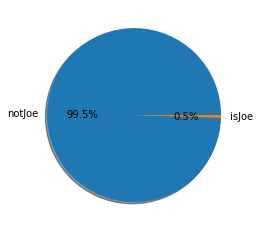

In [16]:
plt.pie(list(100*df.groupby('isJoe').size()/n_entries), labels=['notJoe', 'isJoe'], autopct='%1.1f%%', shadow=True)

##### Separating classes for comparisons

> **pos** dataframe has positive class data and **neg** the negative class data.

In [17]:
pos = df[df['isJoe'] == True].set_index('index')
n_pos_entries = pos.shape[0]

neg = df[df['isJoe'] == False].set_index('index')
n_neg_entries = neg.shape[0]

#### Comparing classes

> Left plot shows the information for positive class and right one for the negative class. Information about the field is also presented: the unique elements for each field and how many unique elements there are

browser:

	- 4 elements
	- ['Chrome', 'Firefox', 'Internet Explorer', 'Safari']



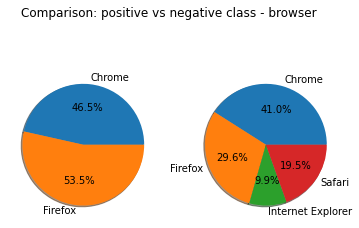

os:

	- 6 elements
	- ['Debian', 'MacOS', 'Ubuntu', 'Windows 10', 'Windows 7', 'Windows 8']



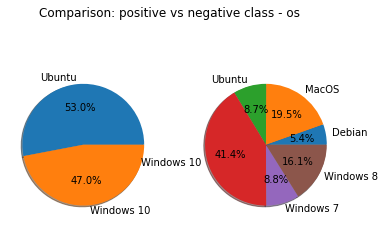

locale:

	- 25 elements
	- ['bg-BG', 'de-DE', 'en-AU', 'en-CA', 'en-GB', 'en-NZ', 'en-SG', 'en-US', 'es-MX', 'fr-FR', 'it-IT', 'ja-JP', 'nl-NL', 'pl-PL', 'pt-BR', 'pt-PT', 'ro-RO', 'ru-RU', 'ru_RU', 'uk-UA', 'ur-PK', 'vi-VN', 'wo-SN', 'xh-ZA', 'zh-CN']



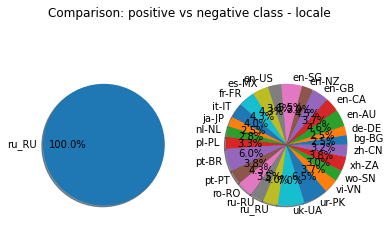

hour:

	- 24 elements
	- [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]



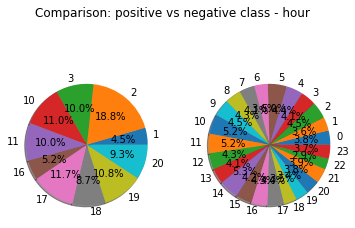

gender:

	- 2 elements
	- ['f', 'm']



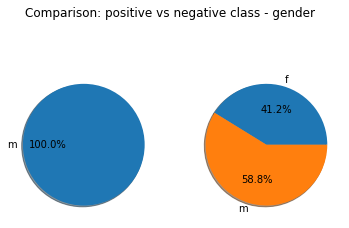

Country:

	- 17 elements
	- ['Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Malaysia', 'Netherlands', 'New Zealand', 'Russia', 'Singapore', 'Spain', 'UK', 'USA']



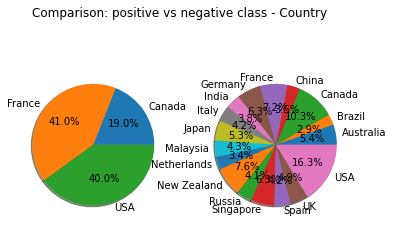

City:

	- 21 elements
	- ['Amsterdam', 'Auckland', 'Berlin', 'Chicago', 'Delhi', 'Kuala Lumpur', 'London', 'Madrid', 'Miami', 'Moscow', 'New York', 'Paris', 'Rio de Janeiro', 'Rome', 'San Francisco', 'Shanghai', 'Singapore', 'Sydney', 'Tokyo', 'Toronto', 'Vancouver']



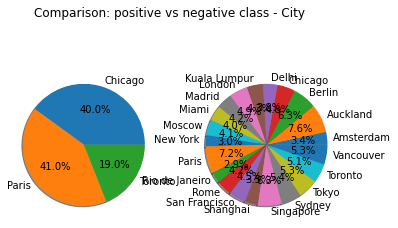

In [18]:
for key in ['browser', 'os', 'locale', 'hour', 'gender', 'Country', 'City']:
    describe_field(df, key)
    
    pos_values = pos.groupby(key).size().reset_index().to_numpy()
    neg_values = neg.groupby(key).size().reset_index().to_numpy()
    
    positive = [i[0] for i in pos_values], [i[1] for i in pos_values]
    negative = [i[0] for i in neg_values], [i[1] for i in neg_values]

    plot_classes_diff(positive, negative, key)

> - **Browser**: there are 4 browsers in the dataset. Joe uses only 2: Chrome and Firefox. The other users also utilize these browsers a lot, but they also use Safari and IE
> - **OS**     : there are 6 browsers in the dataset. Joe uses only 2: Ubuntu and Windows 10. The majority of the other users utilize Windows 10
> - **Locale** : Joe only uses ru_RU;
> - **Hour**   : Joe uses the internet usually in ealry morning (1-3), at the end of the morning (10, 11), in the evening (16 - 20); other users;
> - **Gender**  : 100% of the times Joe accessed the internet the gender information was 'male';
> - **Country** : there are 17 countries, Joe has acessed from 3 different countries
> - **City**    : there are 21 cities, Joe has been in 3

#### Sites_ranked

> Ranking sites to identify the popular ones

In [19]:
# top 10 popular websites
sites_ranked = sites_df.groupby(['site']).size().reset_index().sort_values(0, ascending=False)
sites_ranked['perc'] = sites_ranked[0]*100/n_entries
sites_ranked.iloc[:10]

,site,0,perc
11011,youtube.com,28970,36.21250
9722,toptal.com,21929,27.41125
8899,slack.com,21508,26.88500
5724,lenta.ru,18483,23.10375
10457,vk.com,17507,21.88375
6148,mail.google.com,15990,19.98750
7376,oracle.com,10532,13.16500
10720,wikimedia.org,10521,13.15125
4192,googleapis.com,9437,11.79625
10404,vimeo.com,9055,11.31875


##### Classification of websites
> top (present in more than 10% of the sesssions), medium (it appeared between 5% and 10% of the sessions) and rare (it appeared in less than 5% of the sessions)


In [20]:
sites_ranked['top_sites']  = sites_ranked['perc'] > 10
sites_ranked['med_sites']  = sites_ranked['perc'].between(5, 10)
sites_ranked['rare_sites'] = sites_ranked['perc'] < 5

In [21]:
# saving sites classification for sites, because it will be used afterwards for prediction
sites_ranked[(sites_ranked['perc'] >= 5)][['site', 'top_sites', 'med_sites']].to_csv('sites_classification.csv', index=False)

In [22]:
sites_ranked.head(3)

,site,0,perc,top_sites,med_sites,rare_sites
11011,youtube.com,28970,36.21250,True,False,False
9722,toptal.com,21929,27.41125,True,False,False
8899,slack.com,21508,26.88500,True,False,False


##### percentage of the time spent in each website

> It could be useful to determine which type of content the users spend more time in

In [23]:
sites_length_total = sites_df.groupby('index').agg({'length': 'sum'}).reset_index().rename(columns={'length': 'total'})
sites_df = sites_df.merge(sites_length_total, on='index', how='inner')
sites_df['perc_length'] = sites_df['length'].div(sites_df['total']) * 100
sites_df.head(3)

,index,site,length,total,perc_length
0,0,mail.google.com,50,481,10.395010
1,0,toptal.com,132,481,27.442827
2,0,slack.com,65,481,13.513514


#### Behavior statistics

> per each id we have the percentage of the session spent on the website and an indication of the website type it was (popular, medium, rare). With that information is possible to calculate statistics about the behavior of the user

In [24]:
sites_df = sites_df.merge(sites_ranked.drop(columns=[0, 'perc']), on=['site'], how='inner')
sites_df.head(3)

,index,site,length,total,perc_length,top_sites,med_sites,rare_sites
0,0,mail.google.com,50,481,10.395010,True,False,False
1,17,mail.google.com,330,1890,17.460317,True,False,False
2,22,mail.google.com,144,1128,12.765957,True,False,False


> getting statistics of session as whole and the caracteristics of the behavior in top websites, medium and rare

In [25]:
top_sites = get_stats(sites_df[sites_df['top_sites'] == True], '_top')
med_sites = get_stats(sites_df[sites_df['med_sites'] == True], '_med')
rare_sites = get_stats(sites_df[sites_df['rare_sites'] == True], '_rare')
all_sites = get_stats(sites_df, '_all').drop(columns=['sum_all'])

sites_stats_final = df[['index']].drop_duplicates()\
.merge(top_sites, on='index', how='left')\
.merge(med_sites, on='index', how='left')\
.merge(rare_sites, on='index', how='left')\
.merge(all_sites, on='index', how='left')

sites_stats_final.fillna(0, inplace=True)
sites_stats_final.head(3)

,index,sum_top,size_top,mean_top,min_top,max_top,median_top,mode_f_top,std_top,mean_perc_t_top,...,min_all,max_all,median_all,mode_f_all,std_all,mean_perc_t_all,min_perc_t_all,median_perc_t_all,mode_f_perc_t_all,std_perc_avg_all
0,0,77.546778,5.0,74.6,50.0,132.0,65.0,65.0,32.761258,0.565152,...,50.0,132.0,66.0,66.0,32.319757,0.607323,0.378788,0.500000,0.500000,0.403157
1,1,18.773234,1.0,202.0,202.0,202.0,202.0,202.0,0.000000,1.000000,...,40.0,269.0,109.0,109.0,76.059370,0.444444,0.148699,0.405204,0.405204,0.636184
2,2,8.515625,1.0,109.0,109.0,109.0,109.0,109.0,0.000000,1.000000,...,74.0,376.0,109.0,74.0,124.718922,0.486322,0.196809,0.289894,0.196809,0.682057


> Comparison between positive class and negative class: which type of websites do they spend more time in

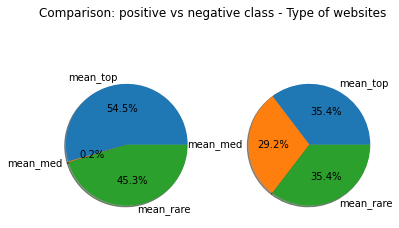

In [26]:
pos_values = sites_stats_final.loc[pos.index][['mean_top', 'mean_med', 'mean_rare']].mean().reset_index().to_numpy()
positive = [i[0] for i in pos_values], [i[1] for i in pos_values]

neg_values = sites_stats_final.loc[neg.index][['mean_top', 'mean_med', 'mean_rare']].mean().reset_index().to_numpy()
negative = [i[0] for i in neg_values], [i[1] for i in neg_values]

plot_classes_diff(positive, negative, 'Type of websites')

> Joe usually spend his time on popular websites and rare ones. The other users tends to divide their time equally among top, medium and rare websites

#### Dummies for websites visited

> For each website out of the top20, indicates which percentage of the session time was spent visiting that site

In [27]:
top20 = sites_ranked.iloc[:20]['site'].unique()
top20

array(['youtube.com', 'toptal.com', 'slack.com', 'lenta.ru', 'vk.com',
       'mail.google.com', 'oracle.com', 'wikimedia.org', 'googleapis.com',
       'vimeo.com', 'airbnb.com', 'geotrust.com', 'google.com',
       'facebook.com', 'booking.com', 'live.com', 'cedexis.com',
       'ggpht.com', 'baidu.com', 'googlevideo.com'], dtype=object)

In [28]:
sites_df['site_top'] = 0
power2 = 0.5
for website in top20:
    power2 = power2*2
    # variable indicates amount of time spent on top website 'website'
    sites_df.loc[sites_df['site'] == website, website] = sites_df['perc_length']
    # site_top column indicates the website visited. afterwards we will sum and we will get a number
    # that represents a combination of websites and we can infer which combinations are more frequent
    sites_df.loc[sites_df['site'] == website, 'site_top'] = power2

In [29]:
sites_dummies = sites_df[['index', 'site_top'] + list(top20)].groupby(['index']).sum().reset_index()
sites_dummies.head(3)

,index,site_top,youtube.com,toptal.com,slack.com,lenta.ru,vk.com,mail.google.com,oracle.com,wikimedia.org,...,airbnb.com,geotrust.com,google.com,facebook.com,booking.com,live.com,cedexis.com,ggpht.com,baidu.com,googlevideo.com
0,0,47.0,13.929314,27.442827,13.513514,12.266112,0.0,10.39501,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
1,1,1.0,18.773234,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
2,2,294913.0,8.515625,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.21875,0.0,0.0,7.421875,0.0


##### top combinations of sites
> Find popular sites that are visited together and indicates if this combination of websites was present in the session

> The combinations are indicated by a sum of power of 2. The dataframe below shows the combinations that appear the most

In [30]:
top_combinations = sites_dummies[['index', 'site_top']].groupby('site_top').size().reset_index().sort_values(0, ascending=False)
top_combinations['perc_top_comb'] = top_combinations[0]*100/sites_dummies.shape[0]

# list with the most commom combinations of websites per session
top_combinations_list = top_combinations.iloc[1:11][['site_top']]
top_combinations_list.to_csv('top_combinations.csv', index=False)

top_combinations.drop(columns=[0]).iloc[:10]

,site_top,perc_top_comb
0,0.0,5.172912
59,63.0,2.385469
1,1.0,2.006105
556,131072.0,1.508661
62,66.0,1.248634
60,64.0,1.222254
21,21.0,1.172007
28,28.0,1.135579
260,8192.0,1.095381
322,16384.0,1.058952


In [31]:
# users with sessions with top combinations
user_top_comb = sites_dummies.merge(top_combinations_list, on=['site_top'], how='inner').set_index('index')

# dummies for top combinations
dummies_top_combinations = pd.get_dummies(user_top_comb['site_top'], prefix='comb_').reset_index()
dummies_top_combinations.head(3)

,index,comb__1.0,comb__18.0,comb__21.0,comb__28.0,comb__63.0,comb__64.0,comb__66.0,comb__8192.0,comb__16384.0,comb__131072.0
0,1,1,0,0,0,0,0,0,0,0,0
1,30,1,0,0,0,0,0,0,0,0,0
2,63,1,0,0,0,0,0,0,0,0,0


In [32]:
dummies_top_combinations.shape

(11022, 11)

### generate dataset for model

> Aggregates all the previous information in order to generate the dataset to train the models

In [33]:
data = sites_stats_final\
.merge(df[['index', 'isJoe', 'hour']], on='index', how='inner').set_index('index')\
.merge(dummies_top_combinations, on=['index'], how='left')\
.merge(sites_dummies, on=['index'], how='left')\
.fillna(0)

data.head(3)

,index,sum_top,size_top,mean_top,min_top,max_top,median_top,mode_f_top,std_top,mean_perc_t_top,...,airbnb.com,geotrust.com,google.com,facebook.com,booking.com,live.com,cedexis.com,ggpht.com,baidu.com,googlevideo.com
0,0,77.546778,5.0,74.6,50.0,132.0,65.0,65.0,32.761258,0.565152,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
1,1,18.773234,1.0,202.0,202.0,202.0,202.0,202.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0
2,2,8.515625,1.0,109.0,109.0,109.0,109.0,109.0,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,19.21875,0.0,0.0,7.421875,0.0


In [34]:
data.shape

(80000, 85)

In [35]:
cols_session = list(set(data.columns) - set(['isJoe']))

In [36]:
browser_dummies = pd.get_dummies(df.set_index('index')[['browser', 'os', 'gender', 'locale', 'Country']], prefix=['browser_', 'os_', 'gender_', 'locale_', 'Country_'])
browser_dummies.head(5)

,browser__Chrome,browser__Firefox,browser__Internet Explorer,browser__Safari,os__Debian,os__MacOS,os__Ubuntu,os__Windows 10,os__Windows 7,os__Windows 8,...,Country__Italy,Country__Japan,Country__Malaysia,Country__Netherlands,Country__New Zealand,Country__Russia,Country__Singapore,Country__Spain,Country__UK,Country__USA
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
data = data\
.merge(browser_dummies, on=['index'], how='left')\
.fillna(0)

In [38]:
data.shape

(80000, 139)

### Modeling

**Features**
> When exploring the variables, it was possible to see that Joe has some very distinctive characteristics, for instance: it was always male gender, only used 2 browsers, only one type of locale. So the characteristics of the session could be useful features in this classification problem.
>> Another possible approach could be to use the session data only and identify Joe just by the way he browses. This option is more robust to an unexpected behavior, for instance Joe browsing in a different city.
Here both approaches were tested and the one that performed better was the one with browser information.

> The client can have relevant information to help guide what is the best approach, but in this first report, the option was to keep the browser and location information.

**Class inbalance and model selection**
> This dataset has an inbalance in the classes. Class inbalance is problematic because it can lead to a model that performs poorly on the minority class (in this project: isJoe = 1). In this project, the Balance Random Forest Classifier from the imbalanced-learn library was used. This class implements data resampling on the bootstrap sample in order to change the class distribution, and allow us to work with a balance dataset in each tree. Undersapling the majority class can be problematic because it can lead to lost of information, but Random Forest reduces the impact of this because of bootstrapping technique in random forest, in which each tree uses a subset of the information available and because there are many trees, different parts of the data are being used.

**Evaluation**
> The evaluation metric used was F1 score. This metric combines recall and precision metrics into one.
- **Recall** is the fraction of the total amount of relevant instances that were actually retrieved, in this project would be the fraction of the Joe sessions that were correctly found.
- **Precision** is the fraction of relevant instances among the retrieved instances, in this project: out of all the sessions labeled Joe by te model, which fraction was actually Joe's.

> In this project, because there are so many instances of not Joe sessions, even a tiny fraction of mistakes in classifying them would influence in the precision of positive class. **Example**: we have 1000 sessions, 995 of them are non Joe and 5 are Joe's. If the classifier gets the notJoe correct 95% of the time, would say that 50 sessions that are not from Joe is his. And if it get all the Joe's right, it would say that 55 sessions are Joe's, when actually just 5 are. So it wasn't precise. On the other hand in this group of 55, all of Joe sessions were there, so the recall is high.

> Depending on the problem, precision or recall can be more important and it could also be discussed with the client. Here, the goal was to have a high recall while also trying to have a good precision

In [39]:
y = data.pop('isJoe')

x = data[cols_session]
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.15, random_state=2)

# info about browser and gender
x_b = data
x_train_b, x_validation_b, y_train_b, y_validation_b = train_test_split(x_b, y, test_size = 0.15, random_state=2)

In [40]:
def train_get_features(scoring, x_train, y_train, x_validation, y_validation, tag):
    
    params = {'n_estimators'     : [50   ,  100, 150],
              'min_samples_split': [0.015, 0.05, 0.1],
              'max_features'     : [0.3  ,  0.5, 0.7] }
    
    
    grid_r = GridSearchCV(BalancedRandomForestClassifier(random_state=10),
                          param_grid = params,        
                          scoring    = scoring,
                          n_jobs     = -1,
                          cv         = 9,
                          verbose    = True)
    
    
    grid_r.fit(x_train, y_train)
    print(grid_r.best_params_)

    best_model = grid_r.best_estimator_
    best_score = grid_r.best_score_

    print('\n\n{}\n'.format(tag))
    print('\nScore training  :\n\t- {}: {}\n'.format(scoring, best_score))

    y_predict = best_model.predict(x_validation)
    
    print('\nScore validation:')
    precision, recall, fscore, support = precision_recall_fscore_support(y_validation, y_predict, average=None)
    print('\n\t- precision        : {}'.format(precision))
    print('\n\t- recall           : {}'.format(recall))
    print('\n\t- fscore           : {}'.format(fscore))
    print('\n\t- support          : {}'.format(support))

    # features df
    features_list = []
    for i in range(0, len(best_model.feature_importances_)):
        l = x_train.columns[i]
        v = best_model.feature_importances_[i]
        features_list.append([l, v])
    features_df = pd.DataFrame(features_list, columns=['feature', 'importance'])
    
    return features_df.sort_values('importance', ascending=False), best_model, y_validation, y_predict

#### Models without the browser features


This model uses f1 score

In [41]:
# f1 score without the browser features
features_df, best_model, y, y_p = train_get_features('f1', x_train, y_train, x_validation, y_validation, 'NO BROWSER')

Fitting 9 folds for each of 27 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.3min finished


{'max_features': 0.7, 'min_samples_split': 0.1, 'n_estimators': 100}


NO BROWSER


Score training  :
	- f1: 0.128333021882557


Score validation:

	- precision        : [0.99892348 0.06096131]

	- recall           : [0.93289209 0.8125    ]

	- fscore           : [0.96477927 0.1134133 ]

	- support          : [11936    64]


> The model had precision of 6.1% for the positive class and 99.9% for the negative one, that means that almost every session it classified as not Joe as not Joe indeed, on the other hand, only 6.7% of the session that were classified as Joe's were actually his. Recall of both classes was high: over 81% of the Joe's sessions were retrieved

For comparison, we also optimized for recall metric

In [42]:
# recall score without the browser features
features_df, best_model, y, y_p = train_get_features('recall', x_train, y_train, x_validation, y_validation, 'NO BROWSER')

Fitting 9 folds for each of 27 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.7min finished


{'max_features': 0.7, 'min_samples_split': 0.015, 'n_estimators': 150}


NO BROWSER


Score training  :
	- recall: 0.9672040461514145


Score validation:

	- precision        : [0.99936697 0.06050955]

	- recall           : [0.92585456 0.890625  ]

	- fscore           : [0.96120727 0.11332008]

	- support          : [11936    64]


> The model had precision of 6% for the positive class and 99.9% for the negative one. Precision didn't change much compared to the previous model, but the recall did: 89% of the Joe's sessions were retrieved.

> This model seems to be a better choice than previous one, but the precision is still low

#### Models WITH the browser features

These models has information of the browser and location of the user, not only the session information as the previous one.


> THe best model was the one optimized for f1 score. The models were also optimized for recall, but the result was not as good as this model. Below we can see the results.


> The f1 score model had precision of 11.6% for the positive class and 100% for the negative one. Comparing to the previous models, precision increased: now all the sessions with the negative label were indeed negative and precision for positive class moved from 5.8% to 11.6%.

> Recall also improved: from 89% to 100% for the positive class and 96% for the negative one.

> This is the best model: all the Joe's of the validation set were retrieved and every session classified as not Joe was not Joe indeed.

##### RECALL

In [43]:
# recall score WITH the browser features
features_df, best_model, y, y_p = train_get_features('recall', x_train_b, y_train_b, x_validation_b, y_validation_b, 'WITH BROWSER')

Fitting 9 folds for each of 27 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  5.0min finished


{'max_features': 0.3, 'min_samples_split': 0.015, 'n_estimators': 50}


WITH BROWSER


Score training  :
	- recall: 1.0


Score validation:

	- precision        : [0.99991266 0.11433757]

	- recall           : [0.95911528 0.984375  ]

	- fscore           : [0.97908916 0.20487805]

	- support          : [11936    64]


##### F1 score

In [44]:
# f1 score WITH the browser features
features_df, best_model, y, y_p = train_get_features('f1', x_train_b, y_train_b, x_validation_b, y_validation_b, 'WITH BROWSER')

Fitting 9 folds for each of 27 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.9min finished


{'max_features': 0.7, 'min_samples_split': 0.015, 'n_estimators': 50}


WITH BROWSER


Score training  :
	- f1: 0.19902294779779572


Score validation:

	- precision        : [1.         0.11594203]

	- recall           : [0.95911528 1.        ]

	- fscore           : [0.97913103 0.20779221]

	- support          : [11936    64]


In [50]:
features_df.iloc[:3]

,feature,importance
114,locale__ru_RU,0.806276
2,size_top,0.067233
67,lenta.ru,0.014031


> The most important features of the selected model was indication if locale is ru_RU or not (Joe only uses ru_RU), number of popular websites in the session; indication of the percentage of time spent on lenta.ru website (joe frequents this website a lot)

### Exporting the model

In [45]:
# saving the model
with open('model.pickle', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)